In [4]:
import os
import numpy as np
import math
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from sklearn.model_selection import LeaveOneOut
import nibabel as nib
from scipy.stats import mannwhitneyu, ttest_ind, ranksums
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from scipy.stats import sem
import scipy
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import random
import matplotlib.colors as mcolors

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
def threshold_tract_vol_by_intensity(vol_tract,intensity_val):
    vol_output = np.zeros_like(vol_tract)
    vol_output[vol_tract == intensity_val] = 1
    #vol_output[vol_tract == intensity_val + 1000] = 1
    return vol_output


def extract_mean_diff(vol,vol_tract,erode_vol=False):

    vol = np.nan_to_num(vol)
    
    if np.count_nonzero(vol_tract) < 20:
        print("potentially bad vol!")
    
    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol_tract = binary_dilation(vol_tract, structure=strel_dil)
    
    masked_array = vol * vol_tract
    mean_intensity = np.nan_to_num(np.sum(masked_array)/np.sum(vol_tract))

    return mean_intensity


def extract_volume(vol,erode_vol=False):
    vol = np.nan_to_num(vol)
    
    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol = binary_dilation(vol, structure=strel_dil)
    
    if np.count_nonzero(vol) < 20:
        print(" ")
        print("   potentially bad vol!")
        print(" ")

    return np.count_nonzero(vol)




def dilate_binary_vol(vol):
    struct_element = np.ones((2, 2, 2), dtype=bool)
    vol_dilated = binary_dilation(vol, structure=struct_element) 
    
    return vol_dilated
    


### DICE ###
def overlap_score_simple(array1, array2):
     

    # Calculate intersection
    intersection = np.sum(array1 & array2)  
    sum_mask1 = np.sum(array1)
    sum_mask2 = np.sum(array2)

    if sum_mask1 + sum_mask2 == 0:  # no intensities present in either. Just set to 0
        ovr_score = 0.0
    else:
        ovr_score = (2. * intersection)/(sum_mask1)

    return ovr_score


    
def list_base_subdirectories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]


def find_repeats(lst):
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1  
    repeats = [item for item, count in counts.items() if count > 1]   
    return repeats

 
    
    
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

# adapted from https://github.com/Netflix/vmaf/
def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

# adapted from https://github.com/Netflix/vmaf/
def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)

# adapted from https://github.com/Netflix/vmaf/
def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    print("aucs are: ", aucs)
    return calc_pvalue(aucs, delongcov)




def identify_non_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        non_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        return non_outliers, outliers


def plot_differences(label_names,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['mathtext.default'] = 'regular'

    num_labels = len(label_names)
    print("num labels is: ", num_labels)

    # Spacing between pairs
    spacing = 20


    fig = plt.figure(figsize=figsize)

    plot_area = [0.3, 0.3, 0.6, 0.6]
    ax = fig.add_axes(plot_area)

    p_array = []

    control_position_list = []
    patient_position_list = []

    y_max = max(np.max(controls), np.max(patients))
    for i, label_name in enumerate(label_names):
        control_data = controls[:, i]
        patient_data = patients[:, i]
        
        # only show extreme outliers (Q1/Q3 += 3IQ)
        control_non_outliers, control_outliers = identify_non_outliers(control_data)
        patient_non_outliers, patient_outliers = identify_non_outliers(patient_data)

        # plot positions
        control_position = i * spacing - 1.5
        patient_position = i * spacing + 6.5

        control_position_list.append(control_position)
        patient_position_list.append(patient_position)

        data = [control_non_outliers, patient_non_outliers]
        positions = [control_position, patient_position]
        vp = plt.violinplot(data, positions=positions, widths=8, showextrema=False, showmedians=True)

        # Color the violin plots
        vp['bodies'][0].set_facecolor('#1F85DE')   # Control violin plot
        vp['bodies'][0].set_edgecolor('black')
        vp['bodies'][0].set_alpha(0.7)

        vp['bodies'][1].set_facecolor('#DE781F')    # Patient violin plot
        vp['bodies'][1].set_edgecolor('black')
        vp['bodies'][1].set_alpha(0.7)


        medianprops = dict(linestyle='-', linewidth=2, color='black')
        boxprops = dict(linestyle='-', linewidth=2, color='black')
        flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='black',markeredgewidth=2)
        whiskerprops = dict(linewidth=2)
        plt.boxplot([control_non_outliers],positions=[control_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)
        plt.boxplot([patient_non_outliers],positions=[patient_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)


        for line in vp['cmedians'].get_segments():
            vp['cmedians'].set_edgecolor('black')

        median_segments = vp['cmedians'].get_segments()
        new_median_segments = []
        for seg in median_segments:
            # seg is a list of two points [x1, y1], [x2, y2]
            mid_point_x = np.mean([seg[0][0], seg[1][0]])
            # Adjust x-coords to shorten the line
            new_seg = [[mid_point_x - 2.2, seg[0][1]], [mid_point_x + 2.2, seg[1][1]]]  # Change 0.5 to adjust the length
            new_median_segments.append(new_seg)

        vp['cmedians'].set_segments(new_median_segments)
        
        # Plot the extreme outliers
        plt.scatter(np.full_like(control_outliers, control_position), control_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)
        plt.scatter(np.full_like(patient_outliers, patient_position), patient_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)


        ###################    

        # 2-tailed Wilcoxon rank-sum
        stat, p = ranksums(control_data, patient_data, alternative='two-sided')

        p_array.append(p)

    # consolidate for FDR correction
    p_array_corrected = multipletests(p_array, method='fdr_bh')[1] 

    for i, label_name in enumerate(label_names):    
        print("label name: ", label_name,  "    uncorrected p_value: ", p_array[i], "    corrected p_value: ", p_array_corrected[i])    
        counter = 0

        p_corr = p_array_corrected[i]
        if 0.01 < p_corr < 0.05:
            text = '*'
            counter += 1
        elif p_corr <= 0.01:
            text = '**'
            counter += 1
        else:
            continue 
        x1, x2 = control_position_list[i], patient_position_list[i]
        y, h, col = max(max(controls[:, i]),max(patients[:, i])) + (y_upper-y_lower)/20, (y_upper-y_lower)/100, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
        plt.text((x1+x2)*.5, y+h-(y_upper-y_lower)/25, text, ha='center', va='bottom', color=col,fontsize=38)

    # Aesthetics
    positions = [i*spacing + 2.5 for i in range(num_labels)]
    plt.xticks(positions, label_names, rotation=45,fontsize=28,fontweight='regular')
    plt.yticks(fontsize=25,fontweight='regular')
    plt.ylim([y_lower,y_upper])
    plt.ylabel(ylab_name, fontsize=32)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    blue_patch = plt.Line2D([], [], marker="o",markeredgecolor='black', markersize=22, linestyle="", color="#1F85DE", label='Controls', alpha=0.7)
    red_patch = plt.Line2D([], [], marker="o",markeredgecolor='black', markersize=22, linestyle="", color="#DE781F", label='TBI', alpha=0.7)
    plt.legend(handles=[blue_patch, red_patch],fontsize=22,prop={'size': 22, 'weight': 'regular'})

    plt.tight_layout()
    plt.tight_layout()
    plt.savefig(fig_save_path, dpi=300)
    plt.show()
    
    
    
    
def roc(controls, patients, scaler=None, flip_preds=False, C=0.1, max_iter=1000, penalty='l2', solver='lbfgs'):
    
    X = np.vstack((controls, patients))
    y = np.hstack((np.zeros(controls.shape[0]), np.ones(patients.shape[0])))
    
    tot = len(controls) + len(patients)
    
    # only needed if multiple features (i.e., not single-feat brainstem)
    if scaler is None:
        X_normalized = X
    else:
        X_normalized = scaler.fit_transform(X)

    loo = LeaveOneOut()

    all_y_test = []
    all_y_scores = []
    y_test_run = []
    y_scores_run = []

    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized[train_index], X_normalized[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LDAClassifier()
        clf.fit(X_train, y_train)
        if flip_preds:
            y_score = clf.predict_proba(X_test)[:, 0]
        else: 
            y_score = clf.predict_proba(X_test)[:, 1]
        y_test_run.extend(y_test)
        y_scores_run.extend(y_score)

    all_y_test.extend(y_test_run)
    all_y_scores.extend(y_scores_run)

    # Compute ROC from aggregate preds
    fpr, tpr, _ = roc_curve(all_y_test, all_y_scores)
    roc_auc = auc(fpr, tpr)
    
    return all_y_test, all_y_scores, fpr, tpr, roc_auc



class LDAClassifier:
    """
    A simple Linear Discriminant Analysis (LDA) classifier.
    """

    def __init__(self):
        self.classes_ = None
        self.means_ = None
        self.priors_ = None
        self.covariance_ = None
        self.covariance_inv_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes_)


        self.means_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)
        cov = np.zeros((n_features, n_features))

        
        for idx, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.means_[idx] = X_cls.mean(axis=0)
            self.priors_[idx] = 1/len(self.classes_)  # flat prior
            cov += np.cov(X_cls, rowvar=False, bias=True) * X_cls.shape[0]

        cov /= X.shape[0]
        self.covariance_ = cov
        self.covariance_inv_ = np.linalg.inv(cov)

    def predict(self, X):
        scores = self.decision_function(X)
        y_pred = self.classes_[np.argmax(scores, axis=1)]
        return y_pred

    def decision_function(self, X):
        X = np.asarray(X)
        scores = []
        for mean, prior in zip(self.means_, self.priors_):
            score = X @ self.covariance_inv_ @ mean - 0.5 * mean @ self.covariance_inv_ @ mean + np.log(prior)
            scores.append(score)
        return np.array(scores).T 

    def predict_proba(self, X):
        scores = self.decision_function(X)
        exp_scores = np.exp(scores)
        # Normalize
        probas = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return probas



In [41]:
base_path_response = "/Users/markolchanyi/Desktop/BSB_validation/RESPONSE_PILOT_FINAL/"


####
DTI_volume_to_use = "fa"
####


#######################################



case_list_control = [
    "sub-R2c001",
    "sub-R2c002",
    "sub-R2c003",
    "sub-R2c004",
    "sub-R2c005",
    "sub-R2c006",
    "sub-R2c007",
    "sub-R2c008",
    "sub-R2c010",
    "sub-R2c012",
    "sub-R2c013",
    "sub-R2c014",
    "sub-R2c015",
    "sub-R2c016",
    "sub-R2c017",
    "sub-TCRc008_ses-1",
    "sub-TCRc010_ses-1",
    "sub-TCRc012_ses-1",
    "sub-TCRc013_ses-1",
    "sub-TCRc014_ses-1",
    "sub-TCRc015_ses-1",
    "sub-TCRc016_ses-1",
    "sub-TCRc017_ses-1",
    "sub-TCRc018_ses-1",
    "sub-TCRc019_ses-1",
    "sub-TCRc020_ses-1",
    "sub-TCRc021_ses-1",
    "sub-TCRc022_ses-1",
    "sub-TCRc023_ses-1"]



case_list_patient = ["sub-TCRp001_ses-early",
                    "sub-TCRp005_ses-early",
                    "sub-TCRp006_ses-early",
                    "sub-TCRp007_ses-early",
                    "sub-TCRp008_ses-early",
                    "sub-TCRp009_ses-early",
                    "sub-TCRp010_ses-early",
                    "sub-TCRp011_ses-early",
                    "sub-TCRp012_ses-early",
                    "sub-TCRp013_ses-early",
                    "sub-TCRp014_ses-early",
                    "sub-TCRp015_ses-early",
                    "sub-TCRp016_ses-early",
                    "sub-TCRp017_ses-early",
                    "sub-TCRp018_ses-early",
                    "sub-TCRp022_ses-early",
                    "sub-TCRp023_ses-early"]


case_list_SWI_artifact = ["sub-TCRp007_ses-early",
                         "sub-TCRp018_ses-early"]


print("length of control cases: ", len(case_list_control))
print("length of patient cases: ", len(case_list_patient))


repeats = find_repeats(case_list_control)
if repeats:
    print("Repeats control:", repeats)
    
repeats = find_repeats(case_list_patient)
if repeats:
    print("Repeats patient:", repeats)


BSB_intensity_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]
BSB_intensity_list_left = [1001,1002,1003,1004,1005,1006,1007,1008]


cwm_volume_list = ["cwm_left","cwm_right"]

label_names = ["left MLc", 
               "right MLc",
               "left SCP",
               "right SCP",
               "left LFB",
               "right LFB",
               "left MHB",
               "right MHB",
               "left Bic",
               "right Bic",
               "left MLr",
               "right MLr",
               "left MLF",
               "right MLF",
               "left CTG",
               "right CTG"]

label_names_nolr = ["MLc", 
                   "SCP",
                   "LFB",
                   "MHB",
                   "Bic",
                   "MLr",
                   "MLF",
                   "CTG"]




'''
tractseg_all_volume_list = ["ILF_left",
                            "ILF_right",
                            "POPT_left",
                            "POPT_right",
                            "T_OCC_left",
                            "T_OCC_right",
                            "ST_OCC_left",
                            "ST_OCC_right",
                            "ST_PAR_left",
                            "ST_PAR_right",
                            "T_PAR_left",
                            "T_PAR_right",
                            "MLF_left",
                            "MLF_right",
                            "OR_left",
                            "OR_right"]
'''

tractseg_all_volume_list = ["ILF_left",
                            "ILF_right",
                            "POPT_left",
                            "POPT_right",
                            "T_OCC_left",
                            "T_OCC_right",
                            "ST_OCC_left",
                            "ST_OCC_right",
                            "ST_PAR_left",
                            "ST_PAR_right",
                            "T_PAR_left",
                            "T_PAR_right",
                            "MLF_left",
                            "MLF_right",
                            "OR_left",
                            "OR_right"]



tractseg_all_volume_list_nolr = ['AF', 
                                 'ATR', 
                                 'CA', 
                                 'CG', 
                                 'CST', 
                                 'MLF', 
                                 'FPT',
                                 'FX',
                                 'ICP',
                                 'IFO',
                                 'ILF',
                                 'MCP',
                                 'OR', 
                                 'POPT',
                                 "SCP",
                                 'SLF_I', 
                                 'SLF_II', 
                                 'SLF_III',
                                 'STR',
                                 'UF', 
                                 'CC', 
                                 'T_PREF',
                                 'T_PREM', 
                                 'T_PREC',
                                 'T_POSTC',
                                 'T_PAR',
                                 'T_OCC', 
                                 'ST_FO',
                                 'ST_PAR', 
                                 'ST_OCC',
                                 'ST_PREF', 
                                 'ST_PREM', 
                                 'ST_PREC', 
                                 'ST_POSTC']

tractseg_all_volume_list_plotting = ["left ILF",
                                    "right ILF",
                                    "left POPT",
                                    "right POPT",
                                    "left T_OCC",
                                    "right T_OCC",
                                    "left ST_OCC",
                                    "right ST_OCC",
                                    "left ST_PAR",
                                    "right ST_PAR",
                                    "left T_PAR",
                                    "right T_PAR",
                                    "left MdLF",
                                    "right MdLF",
                                    "left OR",
                                    "right OR"]

tractseg_cortical_volume_list = ['AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CA', 'CC_1', 'CC_2', 'CC_3', 'CC_4', 'CC_5', 'CC_6',
                   'CC_7', 'CG_left', 'CG_right', 'MLF_left', 'MLF_right', 'FPT_left',
                   'FPT_right', 'FX_left', 'FX_right', 'IFO_left', 'IFO_right', 'ILF_left',
                   'ILF_right', 'OR_left', 'OR_right', 'POPT_left', 'POPT_right',
                   'SLF_I_left', 'SLF_I_right', 'SLF_II_left', 'SLF_II_right', 'SLF_III_left', 'SLF_III_right',
                   'STR_left', 'STR_right', 'UF_left', 'UF_right', 'CC', 'T_PREF_left', 'T_PREF_right', 'T_PREM_left',
                   'T_PREM_right', 'T_PREC_left', 'T_PREC_right', 'T_POSTC_left', 'T_POSTC_right', 'T_PAR_left',
                   'T_PAR_right', 'T_OCC_left', 'T_OCC_right', 'ST_FO_left', 'ST_FO_right', 'ST_PREF_left',
                   'ST_PREF_right', 'ST_PREM_left', 'ST_PREM_right', 'ST_PREC_left', 'ST_PREC_right', 'ST_POSTC_left',
                   'ST_POSTC_right', 'ST_PAR_left', 'ST_PAR_right', 'ST_OCC_left', 'ST_OCC_right']


length of control cases:  29
length of patient cases:  17


In [12]:
#base_path_response = "/Users/markolchanyi/Desktop/BSB_validation/RESPONSE_PILOT/"

for count_case, case in enumerate(case_list_patient):
    print("starting ",case)
    
    dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs_new','bundle_segmentations')
    dir_vol = os.path.join(base_path_response,case,"bsb_outputs_attention_new",DTI_volume_to_use + "_1mm.nii.gz")
    for tract in tractseg_all_volume_list_nolr:
        os.system("mrmath " + os.path.join(dir_tractseg,tract + "_left.nii.gz") + " " + os.path.join(dir_tractseg,tract + "_right.nii.gz") + " max " + os.path.join(dir_tractseg,tract + ".nii.gz") + " -force")
        os.system("mri_convert " + os.path.join(dir_tractseg,tract + ".nii.gz") + " " + os.path.join(dir_tractseg,tract + "_conformed.nii.gz") + " -rl " + dir_vol + " -rt nearest -odt float")
    

starting  sub-TCRp001_ses-early
starting  sub-TCRp005_ses-early
starting  sub-TCRp006_ses-early
starting  sub-TCRp007_ses-early
starting  sub-TCRp008_ses-early
starting  sub-TCRp009_ses-early
starting  sub-TCRp010_ses-early
starting  sub-TCRp011_ses-early
starting  sub-TCRp012_ses-early
starting  sub-TCRp013_ses-early
starting  sub-TCRp014_ses-early
starting  sub-TCRp015_ses-early
starting  sub-TCRp016_ses-early
starting  sub-TCRp017_ses-early
starting  sub-TCRp018_ses-early
starting  sub-TCRp022_ses-early
starting  sub-TCRp023_ses-early


In [5]:
#for count_case, case in enumerate(case_list_control):
#    print("starting ",case)
#    dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs','bundle_segmentations')
    
#    dir_vol = os.path.join(base_path_response,case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")

#    osstr = "mrmath"
#    for count_tract, tract in enumerate(tractseg_cortical_volume_list):
#        osstr += " "
#        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")
#    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"
        
#    os.system(osstr)
#    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_vol + " -rt nearest -odt float")
    




#for count_case, case in enumerate(case_list_patient):
#    print("starting ",case)
#    dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs','bundle_segmentations')
    
#    dir_vol = os.path.join(base_path_response,case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")

#    osstr = "mrmath"
#    for count_tract, tract in enumerate(tractseg_cortical_volume_list):
#        osstr += " "
#        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")
#    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"
        
#    os.system(osstr)
#    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_vol + " -rt nearest -odt float")
    

In [6]:
#for tract in tractseg_all_volume_list_FULL:
    #print("\n\n starting: ",tract)
#    volume_list = []
#    for case in case_list_control:
#        dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs','bundle_segmentations')
#        vol_whole = nib.load(os.path.join(dir_tractseg,tract + ".nii.gz"))
#        vol_whole_np = vol_whole.get_fdata()
#        volume = np.sum(vol_whole_np)
#        print(case,": ",volume)
#        volume_list.append(volume)
#    index_of_lowest = volume_list.index(min(volume_list))
#    print("lowest case: ", case_list_control[index_of_lowest])
    

In [7]:
#for count_case, case in enumerate(case_list_control):
#    print("starting ",count_case)
    
#    dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs','bundle_segmentations')
#    dir_vol = os.path.join(base_path_response,case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")

#    osstr = "mrmath"
#    for count_tract, tract in enumerate(tractseg_all_volume_list):
#        osstr += " "
#        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")
#    osstr += " max " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -force"
        
#    os.system(osstr)
        #os.system("mri_convert " + os.path.join(dir_tractseg,tract + ".nii.gz") + " " + os.path.join(dir_tractseg,tract + "_conformed.nii.gz") + " -rl " + dir_vol + " -rt nearest -odt float")
    

In [8]:

for case in case_list_patient:
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(base_path_response,case,"SWI","ANTs_SWI_outputs","lesions_warped.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(base_path_response,case,"SWI","ANTs_SWI_outputs","lesions_warped_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
            

starting patient:  sub-TCRp001_ses-early
starting patient:  sub-TCRp005_ses-early
starting patient:  sub-TCRp006_ses-early
starting patient:  sub-TCRp007_ses-early
starting patient:  sub-TCRp008_ses-early
starting patient:  sub-TCRp009_ses-early
starting patient:  sub-TCRp010_ses-early
starting patient:  sub-TCRp011_ses-early
starting patient:  sub-TCRp012_ses-early
starting patient:  sub-TCRp013_ses-early
starting patient:  sub-TCRp014_ses-early
starting patient:  sub-TCRp015_ses-early
starting patient:  sub-TCRp016_ses-early
starting patient:  sub-TCRp017_ses-early
starting patient:  sub-TCRp018_ses-early
starting patient:  sub-TCRp022_ses-early
starting patient:  sub-TCRp023_ses-early


In [14]:
base_path_response = "/Users/markolchanyi/Desktop/BSB_validation/RESPONSE_PILOT_FINAL/"

case_list_patient_noartifact = [item for item in case_list_patient if item not in case_list_SWI_artifact]
print(case_list_patient_noartifact)  # Output: ['apple', 'cherry']

all_dice_array = np.zeros((len(case_list_patient_noartifact),len(tractseg_all_volume_list_nolr) + len(label_names_nolr)))

for count_case, case in enumerate(case_list_patient_noartifact):
    print("\n starting case: ", case)
    lesions_path = os.path.join(base_path_response,case,"SWI","ANTs_SWI_outputs","lesions_warped.nii.gz")
    lesions_path_conformed = os.path.join(base_path_response,case,"SWI","ANTs_SWI_outputs","lesions_warped_conformed.nii.gz")
    dir_tractseg = os.path.join(base_path_response,case,'tractseg_outputs_new','bundle_segmentations')
    
    lesion_vol = nib.load(lesions_path)
    lesion_vol_np = lesion_vol.get_fdata()
    lesion_vol_np = lesion_vol_np.astype(bool)
    
    lesion_vol_conformed = nib.load(lesions_path_conformed)
    lesion_vol_conformed_np = lesion_vol_conformed.get_fdata()
    lesion_vol_conformed_np = lesion_vol_conformed_np.astype(bool)
    lesion_vol_conformed_np_dilated = dilate_binary_vol(lesion_vol_conformed_np).astype(bool)
    lesion_vol_np_dilated = dilate_binary_vol(lesion_vol_np)
    
     ##### brainstem ######
    dir_case = os.path.join(base_path_response,case)
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
    
    for count_bs_tracts, intensity in enumerate(BSB_intensity_list_left):
        tract_vol_np_thresholded_left = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        tract_vol_np_thresholded_right = threshold_tract_vol_by_intensity(tract_vol_np,intensity+1000)
        
        tract_vol_np_thresholded = np.logical_or(tract_vol_np_thresholded_left, tract_vol_np_thresholded_right)
        
        # dont apply dilation to brainstem lesions...since ROIs are small no need as this would GREATLY inflate overlap!!
        dice = overlap_score_simple(tract_vol_np_thresholded,lesion_vol_conformed_np)
        all_dice_array[count_case,count_bs_tracts] = dice

    
    for count_tract, tract in enumerate(tractseg_all_volume_list_nolr):
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()  
        
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1).astype(bool)
        
        dice = overlap_score_simple(tract_vol_np_thresholded,lesion_vol_np.astype(bool))
        all_dice_array[count_case,count_tract + count_bs_tracts + 1] = dice
        

['sub-TCRp001_ses-early', 'sub-TCRp005_ses-early', 'sub-TCRp006_ses-early', 'sub-TCRp008_ses-early', 'sub-TCRp009_ses-early', 'sub-TCRp010_ses-early', 'sub-TCRp011_ses-early', 'sub-TCRp012_ses-early', 'sub-TCRp013_ses-early', 'sub-TCRp014_ses-early', 'sub-TCRp015_ses-early', 'sub-TCRp016_ses-early', 'sub-TCRp017_ses-early', 'sub-TCRp022_ses-early', 'sub-TCRp023_ses-early']

 starting case:  sub-TCRp001_ses-early

 starting case:  sub-TCRp005_ses-early

 starting case:  sub-TCRp006_ses-early

 starting case:  sub-TCRp008_ses-early

 starting case:  sub-TCRp009_ses-early

 starting case:  sub-TCRp010_ses-early

 starting case:  sub-TCRp011_ses-early

 starting case:  sub-TCRp012_ses-early

 starting case:  sub-TCRp013_ses-early

 starting case:  sub-TCRp014_ses-early

 starting case:  sub-TCRp015_ses-early

 starting case:  sub-TCRp016_ses-early

 starting case:  sub-TCRp017_ses-early

 starting case:  sub-TCRp022_ses-early

 starting case:  sub-TCRp023_ses-early


In [15]:
import matplotlib
matplotlib.use('Agg')

# Setting the font to Arial and bold for the plot
plt.rcParams['font.family'] = 'Arial'


## rename MLF in tractseg to MdLF, to avoid confusion with middle longitudinal facicle/medial longitudial 
## fascuculus and rename SCP to SCPt to disambiguate with BSB SCP
tractseg_all_volume_list_nolr_mlf_renamed = tractseg_all_volume_list_nolr.copy()
index_SCP = tractseg_all_volume_list_nolr.index('SCP')
index_MLF = tractseg_all_volume_list_nolr.index('MLF')
tractseg_all_volume_list_nolr_mlf_renamed[index_SCP] = 'SCPt'
tractseg_all_volume_list_nolr_mlf_renamed[index_MLF] = 'MdLF'

for count, tract in enumerate(tractseg_all_volume_list_nolr_mlf_renamed):
    tract_renamed = tract.replace('_', '')
    tractseg_all_volume_list_nolr_mlf_renamed[count] = tract_renamed
    


case_list_patient_explicit = ["p1","p3","p4","p6","p7","p8","p9",
                             "p10","p11","p12","p13","p14","p15","p17","p18"]


hex_color = "#DE781F"  # Color from patient violin plot
color2 = "white"  # Blend with white

# Create a colormap that transitions from your hex color to the second color
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [color2, hex_color])

vmin = 0
vmax = 0.15
# Create the heatmap
fig = plt.figure(figsize=(60, 10))

plot_area = [0.3, 0.3, 0.6, 0.6]
ax = fig.add_axes(plot_area)

plt.imshow(all_dice_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax, aspect=1.13)

# Add color bar
cbar = plt.colorbar(shrink=0.8, aspect=15, pad=0.005)
cbar.set_label('Lesion Overlap Dice', rotation=270, labelpad=-28, fontsize=28, fontweight='regular')

# Set colorbar ticks at the top and bottom
cbar_min, cbar_max = vmin, vmax
cbar.set_ticks([cbar_min, cbar_max])
cbar.ax.tick_params(labelsize=28)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight('normal')

# Set tick labels for the y-axis
plt.yticks(ticks=np.arange(len(case_list_patient_explicit)), labels=case_list_patient_explicit, fontsize=28, fontweight='regular')

# Get the list of x-tick positions (based on number of labels)
xtick_positions = np.arange(len(tractseg_all_volume_list_nolr_mlf_renamed + label_names_nolr)) + 0.5
xtick_positions_extended = (xtick_positions*1.4)-10

# Remove default xtick labels (since we will add our own annotations)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([])  # Remove the original xtick labels

ax.tick_params(axis='x', which='both', length=0)

ax = plt.gca()
# Annotate with labels BELOW the plot and draw lines
for i, tract in enumerate(label_names_nolr + tractseg_all_volume_list_nolr_mlf_renamed):
    if tract in label_names_nolr:  # Assuming brainstem labels are in 'label_names_nolr'
        tract_color = 'red'
    else:
        tract_color = 'black'  # Default color for non-brainstem labels
    # Adding the label below the axis
    ax.annotate(
        tract,  # The text label
        xy=(xtick_positions[i]-0.5 , 14.5),  # The tick position, just below the x-axis
        xytext=(xtick_positions_extended[i], 18.5),  # Move the text far below the x-axis
        ha='center',  # Center alignment for the labels
        va='top',  # Vertical alignment to position above the annotation point
        fontsize=24,  # Font size for labels
        color=tract_color,
        rotation=45,
        rotation_mode='anchor',
        annotation_clip=False,
        clip_on=False,
        arrowprops=dict(
            arrowstyle='-', 
            lw=1.5,  # Line width
            color=tract_color,
            relpos=(0.75, 0.75),
            connectionstyle="arc,angleA=90,angleB=0,armA=45,armB=0,rad=0",  # Creates a diagonal line pointing from the original tick to the extended label
        )
    )
    

# Show the plot
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/TBI_lesion_heatmap.png', dpi=fig.dpi)
plt.show()

<ipython-input-15-b30ad1c7d95c>:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area
<ipython-input-15-b30ad1c7d95c>:99: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [17]:

all_volume_list = label_names_nolr + tractseg_all_volume_list_nolr

dice_per_tract = np.average(all_dice_array,axis=0)

sorted_indices = np.argsort(dice_per_tract)[::-1]
sorted_dice_per_tract = dice_per_tract[sorted_indices]
sorted_all_volume_list = [all_volume_list[i] for i in sorted_indices]

for count, tract in enumerate(sorted_all_volume_list):
    
    print(tract, " dice: ", sorted_dice_per_tract[count])


CTG  dice:  0.11290513172949344
MHB  dice:  0.1094967814024454
MLr  dice:  0.09184944915974926
LFB  dice:  0.062346785559513763
MLF  dice:  0.05531774243023325
SCP  dice:  0.04584981414148258
Bic  dice:  0.02679921461254794
ILF  dice:  0.025937279058311516
T_OCC  dice:  0.025536041626536457
OR  dice:  0.025307059407523865
MLc  dice:  0.02511637625032772
ST_OCC  dice:  0.02240602930851591
T_PAR  dice:  0.019831395010174186
POPT  dice:  0.018419869749524136
MLF  dice:  0.018193841595354848
ST_PAR  dice:  0.01800142540264594
STR  dice:  0.017989148562764793
AF  dice:  0.017920873884008075
SLF_I  dice:  0.017218150835384156
CC  dice:  0.01661130551646407
IFO  dice:  0.01621813493066511
SCP  dice:  0.015150928983733445
T_PREM  dice:  0.01504080337591531
ATR  dice:  0.014142567759983977
SLF_III  dice:  0.01408567412210591
T_PREF  dice:  0.012410255243818898
T_POSTC  dice:  0.011776034767929133
FPT  dice:  0.011091310008968245
T_PREC  dice:  0.010414979639885903
ST_PREF  dice:  0.010263101671

In [ ]:
##### reformat tractseg volumes

for case in case_list_control:
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    print("starting control: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
        
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
        

In [ ]:
##### reformat at tractseg volumes
#for case in case_list_patient:
#    dir_case = os.path.join(base_path_response,case)
#    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
#    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + _1mm_conformed.nii.gz")
#    print("starting: ",case)
#    if os.path.isfile(dir_vol):
#        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
#    else:
#        print("full vol does not exist!")
        
#for case in case_list_control:
#    dir_case = os.path.join(base_path_response,case)
#    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
#    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz")
#    print("starting: ",case)
#    if os.path.isfile(dir_vol):
#        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
#    else:
#        print("full vol does not exist!")
        
        

In [14]:
##### for BSB ######

case_list_control_pruned = case_list_control
case_list_patient_pruned = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned))
print("length of pruned control cases: ", len(case_list_control_pruned))
controls_bsb = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))

controls_bsb_volume = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb_volume = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))


counter = 0
for case in case_list_patient_pruned:
    print("starting patients: ",case)
    dir_case = os.path.join(base_path_response,case)
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()
    
    vol_whole = nib.load(os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz"))
    vol_whole_np = vol_whole.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                          
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        volm = extract_volume(tract_vol_np_thresholded)
        patients_bsb[counter,counter_tract] = mean_diff
        patients_bsb_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1

counter = 0
for case in case_list_control_pruned:
    print("starting controls: ",case)
    dir_case = os.path.join(base_path_response,case)
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata() 
     
    vol_whole = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz"))
    vol_whole_np = vol_whole.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_raw","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                             
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        volm = extract_volume(tract_vol_np_thresholded)
        controls_bsb[counter,counter_tract] = mean_diff
        controls_bsb_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1

length of pruned patient cases:  17
length of pruned control cases:  29
starting patients:  sub-TCRp001_ses-early
starting patients:  sub-TCRp005_ses-early
starting patients:  sub-TCRp006_ses-early
starting patients:  sub-TCRp007_ses-early
starting patients:  sub-TCRp008_ses-early
starting patients:  sub-TCRp009_ses-early
starting patients:  sub-TCRp010_ses-early
starting patients:  sub-TCRp011_ses-early
starting patients:  sub-TCRp012_ses-early
starting patients:  sub-TCRp013_ses-early
starting patients:  sub-TCRp014_ses-early
starting patients:  sub-TCRp015_ses-early
starting patients:  sub-TCRp016_ses-early
starting patients:  sub-TCRp017_ses-early
potentially bad vol!
 
   potentially bad vol!
 
potentially bad vol!
 
   potentially bad vol!
 
starting patients:  sub-TCRp018_ses-early
starting patients:  sub-TCRp022_ses-early
starting patients:  sub-TCRp023_ses-early
starting controls:  sub-R2c001
starting controls:  sub-R2c002
starting controls:  sub-R2c003
starting controls:  sub

num labels is:  16
label name:  left MLc     uncorrected p_value:  0.002979834522686171     corrected p_value:  0.011919338090744684
label name:  right MLc     uncorrected p_value:  0.05740378112217077     corrected p_value:  0.11480756224434154
label name:  left SCP     uncorrected p_value:  0.08576629407763228     corrected p_value:  0.1524734116935685
label name:  right SCP     uncorrected p_value:  0.16857139302662083     corrected p_value:  0.24519475349326667
label name:  left LFB     uncorrected p_value:  6.499990404078988e-05     corrected p_value:  0.001039998464652638
label name:  right LFB     uncorrected p_value:  0.0018941009368237814     corrected p_value:  0.010101871663060168
label name:  left MHB     uncorrected p_value:  0.22341078889862265     corrected p_value:  0.2553266158841402
label name:  right MHB     uncorrected p_value:  0.24119938367115257     corrected p_value:  0.25727934258256274
label name:  left Bic     uncorrected p_value:  0.026498702194376562     co

<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


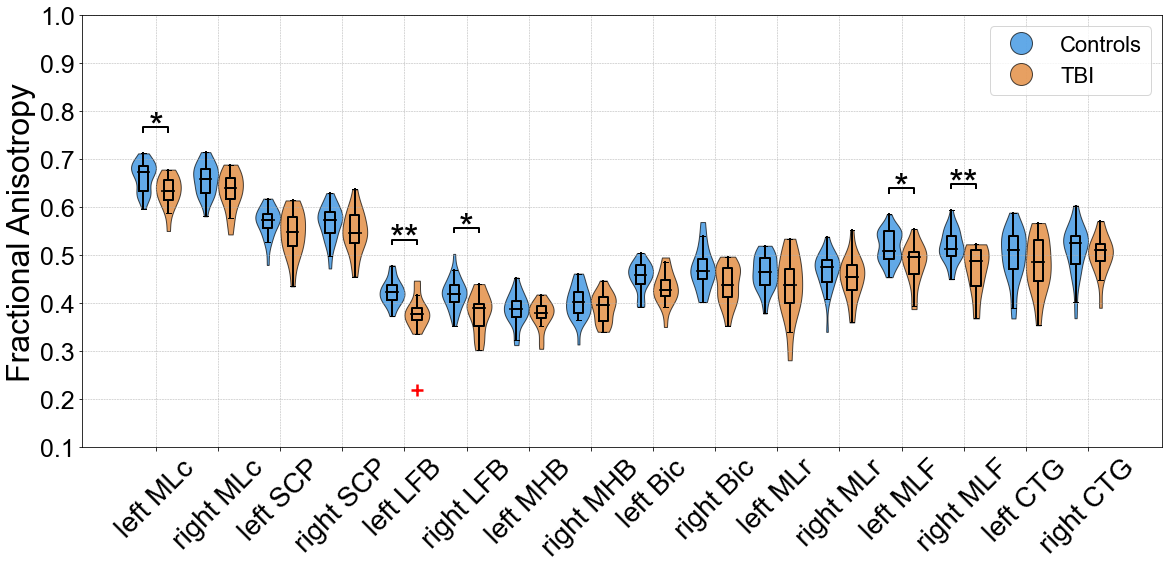

In [24]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_BSB.png'
ylab_name= 'Fractional Anisotropy'
labels = label_names
y_lower = 0.1
y_upper = 1.0
figsize = (25, 10)
controls = controls_bsb
patients = patients_bsb


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  16
label name:  left MLc     uncorrected p_value:  0.9094075598211574     corrected p_value:  0.9700347304759013
label name:  right MLc     uncorrected p_value:  0.990921399014242     corrected p_value:  0.990921399014242
label name:  left SCP     uncorrected p_value:  0.006316924632956495     corrected p_value:  0.10107079412730392
label name:  right SCP     uncorrected p_value:  0.032421588387865206     corrected p_value:  0.25937270710292165
label name:  left LFB     uncorrected p_value:  0.6820780896083436     corrected p_value:  0.7795178166952498
label name:  right LFB     uncorrected p_value:  0.21911412926950524     corrected p_value:  0.473322874650725
label name:  left MHB     uncorrected p_value:  0.6086256030680439     corrected p_value:  0.7490776653145156
label name:  right MHB     uncorrected p_value:  0.5020061969230474     corrected p_value:  0.7286206180226728
label name:  left Bic     uncorrected p_value:  0.5314316035887405     corrected p_value:  0.

<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


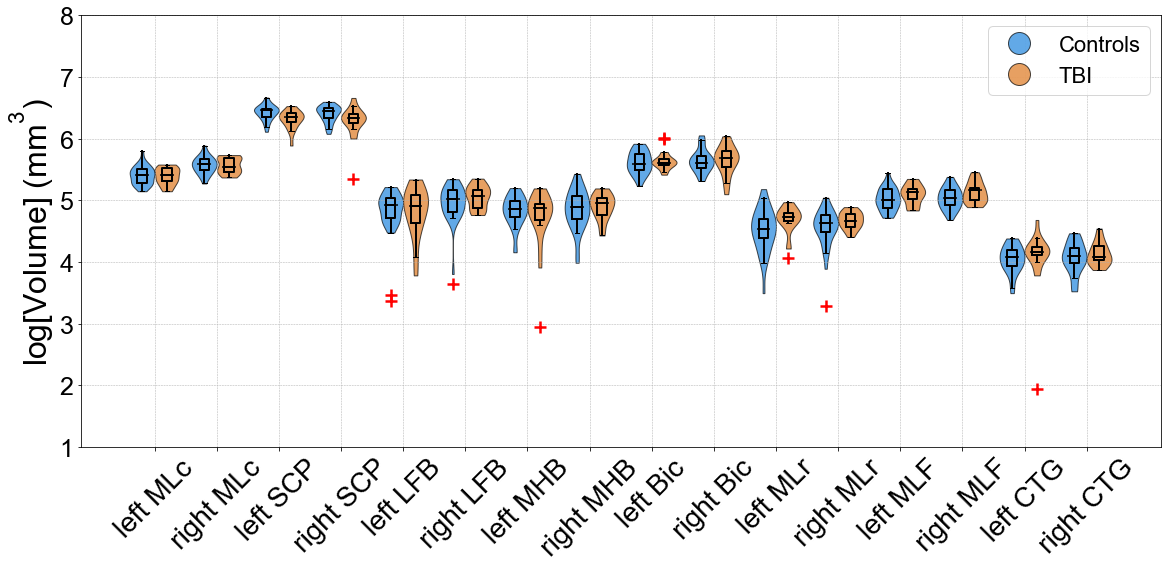

In [25]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_BSB_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = label_names
y_lower = 1.0
y_upper = 8.0
figsize = (25, 10)
controls = np.log(controls_bsb_volume)
patients = np.log(patients_bsb_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [21]:
##### reformat all tractseg volumes
'''
for case in case_list_control:
    dir_case = os.path.join(base_path_response,case)
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs_new','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    print("starting control: ",case)
    if os.path.isfile(dir_fa):
        for tract in tractseg_cortical_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                print("exists!")
                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")   
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_response,case)
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs_new','bundle_segmentations')
    dir_fa = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_fa):
        for tract in tractseg_cortical_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                print("exists!")
                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
           
'''          

'\nfor case in case_list_control:\n    dir_case = os.path.join(base_path_response,case)\n    dir_tractseg = os.path.join(dir_case,\'tractseg_outputs_new\',\'bundle_segmentations\')\n    dir_fa = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")\n    print("starting control: ",case)\n    if os.path.isfile(dir_fa):\n        for tract in tractseg_cortical_volume_list:\n            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):\n                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")\n            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):\n                print("exists!")\n                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt n

In [27]:

case_list_control_pruned_tractseg = case_list_control
case_list_patient_pruned_tractseg = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_tractseg))
controls_bsb_tractseg = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_all_volume_list)))
patients_bsb_tractseg = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_all_volume_list)))

controls_bsb_tractseg_volume = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_all_volume_list)))
patients_bsb_tractseg_volume = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_all_volume_list)))



counter = 0
for case in case_list_control_pruned_tractseg:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs_new','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
                      
    counter_tract = 0
    for tract in tractseg_all_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded)
        controls_bsb_tractseg[counter,counter_tract] = mean_diff
        controls_bsb_tractseg_volume[counter,counter_tract] = volm
        counter_tract += 1
    
    counter += 1


counter = 0
for case in case_list_patient_pruned_tractseg:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs_new','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
                      
    counter_tract = 0
    for tract in tractseg_all_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded)
        patients_bsb_tractseg[counter,counter_tract] = mean_diff
        patients_bsb_tractseg_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1



length of pruned patient cases:  17
starting control:  sub-R2c001
starting control:  sub-R2c002
starting control:  sub-R2c003
starting control:  sub-R2c004
starting control:  sub-R2c005
starting control:  sub-R2c006
starting control:  sub-R2c007
starting control:  sub-R2c008
starting control:  sub-R2c010
starting control:  sub-R2c012
starting control:  sub-R2c013
starting control:  sub-R2c014
starting control:  sub-R2c015
starting control:  sub-R2c016
starting control:  sub-R2c017
starting control:  sub-TCRc008_ses-1
starting control:  sub-TCRc010_ses-1
starting control:  sub-TCRc012_ses-1
starting control:  sub-TCRc013_ses-1
starting control:  sub-TCRc014_ses-1
starting control:  sub-TCRc015_ses-1
starting control:  sub-TCRc016_ses-1
starting control:  sub-TCRc017_ses-1
starting control:  sub-TCRc018_ses-1
starting control:  sub-TCRc019_ses-1
starting control:  sub-TCRc020_ses-1
starting control:  sub-TCRc021_ses-1
starting control:  sub-TCRc022_ses-1
starting control:  sub-TCRc023_se

num labels is:  16
label name:  left ILF     uncorrected p_value:  0.002979834522686171     corrected p_value:  0.005959669045372342
label name:  right ILF     uncorrected p_value:  0.0037133449975595436     corrected p_value:  0.006601502217883633
label name:  left POPT     uncorrected p_value:  0.002045148410340799     corrected p_value:  0.004674624937921827
label name:  right POPT     uncorrected p_value:  0.0009290738346560131     corrected p_value:  0.0037162953386240525
label name:  left T_OCC     uncorrected p_value:  0.2899604617383441     corrected p_value:  0.3433808577546961
label name:  right T_OCC     uncorrected p_value:  0.5771512700687687     corrected p_value:  0.5771512700687687
label name:  left ST_OCC     uncorrected p_value:  0.06045419263474497     corrected p_value:  0.08060559017965996
label name:  right ST_OCC     uncorrected p_value:  0.04645315817935409     corrected p_value:  0.06756823007906049
label name:  left ST_PAR     uncorrected p_value:  0.001753362

<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


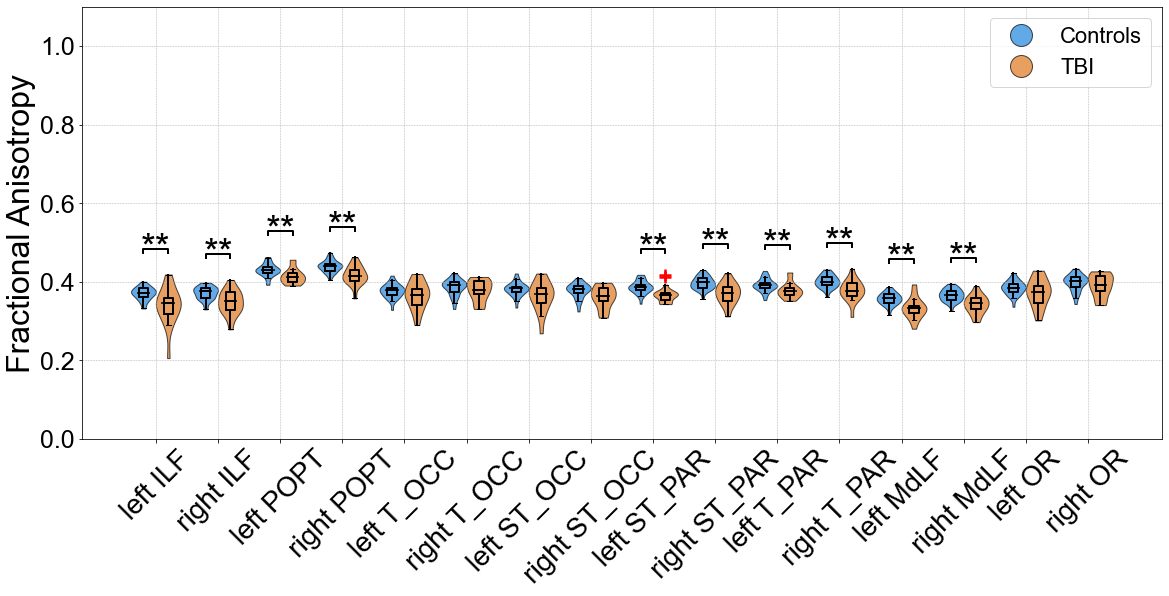

In [28]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_tractseg.png'
ylab_name= 'Fractional Anisotropy'
labels = tractseg_all_volume_list_plotting
y_lower = 0.0
y_upper = 1.1
figsize = (25, 10)
controls = controls_bsb_tractseg
patients = patients_bsb_tractseg


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  16
label name:  left ILF     uncorrected p_value:  0.04901109737055386     corrected p_value:  0.32242236071863983
label name:  right ILF     uncorrected p_value:  0.06045419263474497     corrected p_value:  0.32242236071863983
label name:  left POPT     uncorrected p_value:  0.6086256030680439     corrected p_value:  0.7417212472467278
label name:  right POPT     uncorrected p_value:  0.5771512700687687     corrected p_value:  0.7417212472467278
label name:  left T_OCC     uncorrected p_value:  0.2899604617383441     corrected p_value:  0.5154852653126117
label name:  right T_OCC     uncorrected p_value:  0.1245116722449982     corrected p_value:  0.3320311259866619
label name:  left ST_OCC     uncorrected p_value:  0.6490060913408868     corrected p_value:  0.7417212472467278
label name:  right ST_OCC     uncorrected p_value:  0.41915995415374074     corrected p_value:  0.6289190524188512
label name:  left ST_PAR     uncorrected p_value:  0.039444088120179285     corr

<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


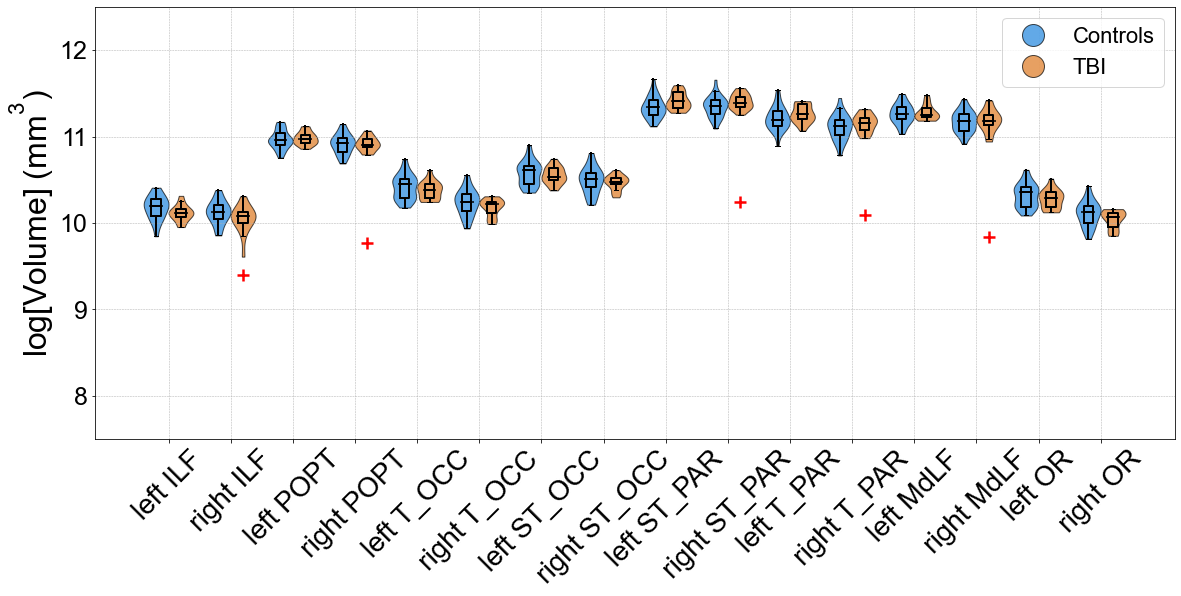

In [29]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_tractseg_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = tractseg_all_volume_list_plotting
y_lower = 7.5
y_upper = 12.5
figsize = (25, 10)
controls = np.log(controls_bsb_tractseg_volume)
patients = np.log(patients_bsb_tractseg_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [30]:
###### for brainstem only!!! #######
case_list_control_pruned_brainstem = case_list_control
case_list_patient_pruned_brainstem = case_list_patient



print("length of pruned patient cases: ", len(case_list_patient_pruned_brainstem))
controls_bsb_brainstem = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem = np.zeros((len(case_list_patient_pruned_brainstem),1))

controls_bsb_brainstem_volume = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem_volume = np.zeros((len(case_list_patient_pruned_brainstem),1))

print("length control: ", len(case_list_control_pruned_brainstem))
print("length patient: ", len(case_list_patient_pruned_brainstem))

counter = 0
for case in case_list_control_pruned_brainstem:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(dir_vol)
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded,erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded,erode_vol=True)
    controls_bsb_brainstem[counter,0] = mean_diff
    controls_bsb_brainstem_volume[counter,0] = volm
    counter += 1
      

counter = 0
for case in case_list_patient_pruned_brainstem:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded,erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded,erode_vol=True)
    patients_bsb_brainstem[counter,0] = mean_diff
    patients_bsb_brainstem_volume[counter,0] = volm
    counter += 1


length of pruned patient cases:  17
length control:  29
length patient:  17
starting control:  sub-R2c001
starting control:  sub-R2c002
starting control:  sub-R2c003
starting control:  sub-R2c004
starting control:  sub-R2c005
starting control:  sub-R2c006
starting control:  sub-R2c007
starting control:  sub-R2c008
starting control:  sub-R2c010
starting control:  sub-R2c012
starting control:  sub-R2c013
starting control:  sub-R2c014
starting control:  sub-R2c015
starting control:  sub-R2c016
starting control:  sub-R2c017
starting control:  sub-TCRc008_ses-1
starting control:  sub-TCRc010_ses-1
starting control:  sub-TCRc012_ses-1
starting control:  sub-TCRc013_ses-1
starting control:  sub-TCRc014_ses-1
starting control:  sub-TCRc015_ses-1
starting control:  sub-TCRc016_ses-1
starting control:  sub-TCRc017_ses-1
starting control:  sub-TCRc018_ses-1
starting control:  sub-TCRc019_ses-1
starting control:  sub-TCRc020_ses-1
starting control:  sub-TCRc021_ses-1
starting control:  sub-TCRc022

num labels is:  1
label name:  Whole Brainstem     uncorrected p_value:  0.011167150307767649     corrected p_value:  0.011167150307767649


<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


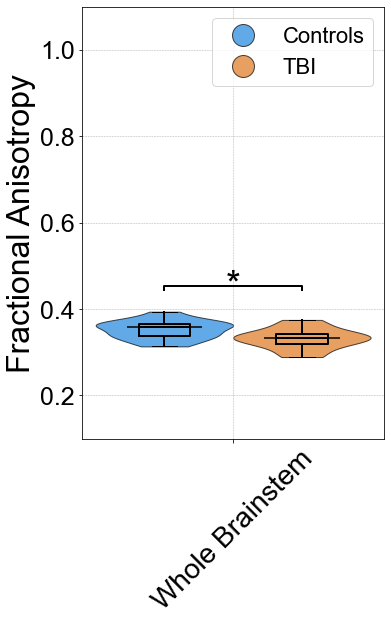

In [31]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_BRAINSTEM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["Whole Brainstem"]
y_lower = 0.1
y_upper = 1.1
figsize = (7, 10)
controls = controls_bsb_brainstem
patients = patients_bsb_brainstem


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  1
label name:  Whole Brainstem     uncorrected p_value:  0.5166103284192662     corrected p_value:  0.5166103284192662


<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


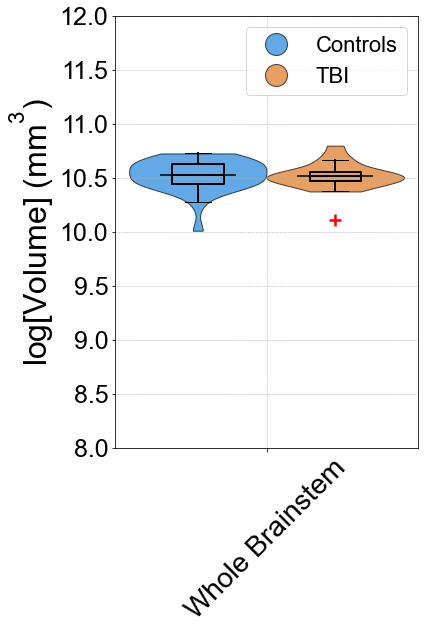

In [32]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_BRAINSTEM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["Whole Brainstem"]
y_lower = 8
y_upper = 12
figsize = (7, 10)
controls = np.log(controls_bsb_brainstem_volume)
patients = np.log(patients_bsb_brainstem_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [33]:
### FOR CORTICAL WHITE MATTER

case_list_control_pruned_cwm = case_list_control
case_list_patient_pruned_cwm = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_cwm))
controls_bsb_cwm = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))

controls_bsb_cwm_volume = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm_volume = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))

counter = 0
for case in case_list_patient_pruned_cwm:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)
    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm_left = extract_volume(seg_vol_np_thresholded_left)
    patients_bsb_cwm[counter,0] = mean_diff_left
    patients_bsb_cwm_volume[counter,0] = volm_left

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm_right = extract_volume(seg_vol_np_thresholded_right)
    patients_bsb_cwm[counter,1] = mean_diff_right
    patients_bsb_cwm_volume[counter,1] = volm_right
    counter += 1



counter = 0
for case in case_list_control_pruned_cwm:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_response,case)
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)
    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm_left = extract_volume(seg_vol_np_thresholded_left)
    controls_bsb_cwm[counter,0] = mean_diff_left
    controls_bsb_cwm_volume[counter,0] = volm_left

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm_right = extract_volume(seg_vol_np_thresholded_right)
    controls_bsb_cwm[counter,1] = mean_diff_right
    controls_bsb_cwm_volume[counter,1] = volm_right
    counter += 1
    
    

length of pruned patient cases:  17
starting patient:  sub-TCRp001_ses-early
starting patient:  sub-TCRp005_ses-early
starting patient:  sub-TCRp006_ses-early
starting patient:  sub-TCRp007_ses-early
starting patient:  sub-TCRp008_ses-early
starting patient:  sub-TCRp009_ses-early
starting patient:  sub-TCRp010_ses-early
starting patient:  sub-TCRp011_ses-early
starting patient:  sub-TCRp012_ses-early
starting patient:  sub-TCRp013_ses-early
starting patient:  sub-TCRp014_ses-early
starting patient:  sub-TCRp015_ses-early
starting patient:  sub-TCRp016_ses-early
starting patient:  sub-TCRp017_ses-early
starting patient:  sub-TCRp018_ses-early
starting patient:  sub-TCRp022_ses-early
starting patient:  sub-TCRp023_ses-early
starting control:  sub-R2c001
starting control:  sub-R2c002
starting control:  sub-R2c003
starting control:  sub-R2c004
starting control:  sub-R2c005
starting control:  sub-R2c006
starting control:  sub-R2c007
starting control:  sub-R2c008
starting control:  sub-R2c0

num labels is:  2
label name:  left Hemispheric GM     uncorrected p_value:  0.03731681380550157     corrected p_value:  0.07463362761100314
label name:  right Hemispheric GM     uncorrected p_value:  0.48762347802524597     corrected p_value:  0.48762347802524597


<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


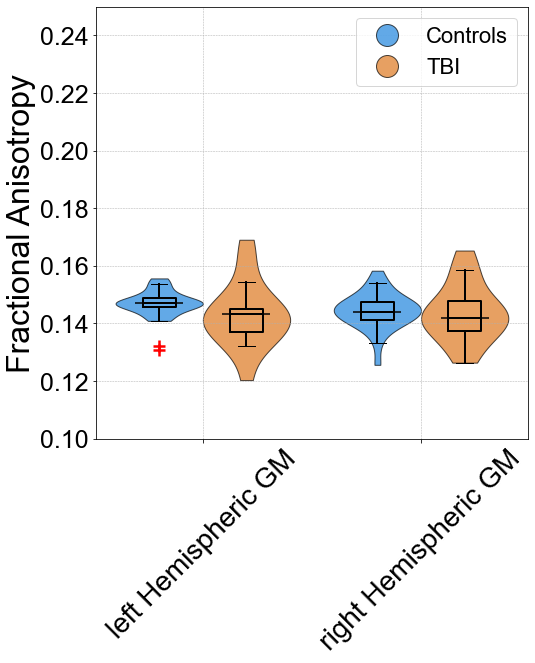

In [34]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_CWM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = 0.1
y_upper = 0.25
figsize = (10, 10)
controls = controls_bsb_cwm
patients = patients_bsb_cwm


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  2
label name:  left Hemispheric GM     uncorrected p_value:  0.1549324870401808     corrected p_value:  0.16857139302662083
label name:  right Hemispheric GM     uncorrected p_value:  0.16857139302662083     corrected p_value:  0.16857139302662083


<ipython-input-5-08d9e5f37ab6>:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-5-08d9e5f37ab6>:343: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


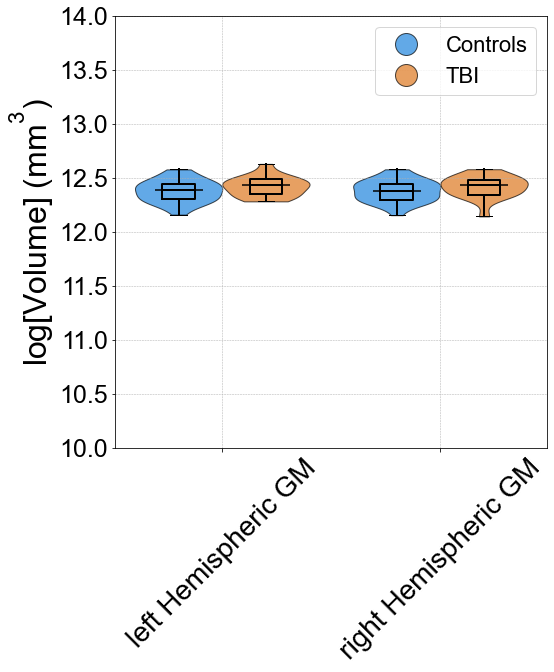

In [35]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/TBI_violin_CWM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = 10
y_upper = 14
figsize = (10, 10)
controls = np.log(controls_bsb_cwm_volume)
patients = np.log(patients_bsb_cwm_volume)


plot_differences(labels,controls,patients,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [48]:
C=0.2
pen='l2'
sol='svd'


####################### for FA ##########################

scaler = StandardScaler()  # normalize the data for classification, only needed for multiple feats (not brainstem)

all_y_test, all_y_scores, fpr, tpr, roc_auc = roc(controls_bsb, 
                                                  patients_bsb, 
                                                  scaler=scaler,
                                                  flip_preds=False,
                                                  C=C, 
                                                  penalty=pen, 
                                                  solver=sol)


all_y_test_tractseg, all_y_scores_tractseg, fpr_tractseg, tpr_tractseg, roc_auc_tractseg = roc(controls_bsb_tractseg, 
                                                                                      patients_bsb_tractseg, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=pen, 
                                                                                      solver=sol)

# single feature so no scaling
all_y_test_brainstem, all_y_scores_brainstem, fpr_brainstem, tpr_brainstem, roc_auc_brainstem = roc(controls_bsb_brainstem, 
                                                                                                   patients_bsb_brainstem, 
                                                                                                   scaler=scaler,
                                                                                                   flip_preds=False,
                                                                                                   C=C, 
                                                                                                   penalty=pen, 
                                                                                                   solver=sol)

all_y_test_cwm, all_y_scores_cwm, fpr_cwm, tpr_cwm, roc_auc_cwm = roc(controls_bsb_cwm, 
                                                  patients_bsb_cwm, 
                                                  scaler=scaler,
                                                  flip_preds=False,
                                                  C=C, 
                                                  penalty=pen, 
                                                  solver=sol)


####################### for volumes ##########################

all_y_test_volume, all_y_scores_volume, fpr_volume, tpr_volume, roc_auc_volume = roc(controls_bsb_volume, 
                                                                                      patients_bsb_volume, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=pen, 
                                                                                      solver=sol)

all_y_test_tractseg_volume, all_y_scores_tractseg_volume, fpr_tractseg_volume, tpr_tractseg_volume, roc_auc_tractseg_volume = roc(controls_bsb_tractseg_volume, 
                                                                                                                              patients_bsb_tractseg_volume, 
                                                                                                                              scaler=scaler,
                                                                                                                              flip_preds=False,
                                                                                                                              C=C, 
                                                                                                                              penalty=pen, 
                                                                                                                              solver=sol)

# single feature so no scaling
all_y_test_brainstem_volume, all_y_scores_brainstem_volume, fpr_brainstem_volume, tpr_brainstem_volume, roc_auc_brainstem_volume = roc(controls_bsb_brainstem_volume, 
                                                                                                                                   patients_bsb_brainstem_volume, 
                                                                                                                                   scaler=scaler,
                                                                                                                                   flip_preds=True,
                                                                                                                                   C=C, 
                                                                                                                                   penalty=pen, 
                                                                                                                                   solver=sol)


all_y_test_cwm_volume, all_y_scores_cwm_volume, fpr_cwm_volume, tpr_cwm_volume, roc_auc_cwm_volume = roc(controls_bsb_cwm_volume, 
                                                                                                      patients_bsb_cwm_volume, 
                                                                                                      scaler=scaler,
                                                                                                      flip_preds=True,
                                                                                                      C=C, 
                                                                                                      penalty=pen, 
                                                                                                      solver=sol)



<ipython-input-49-66cf1951b5da>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


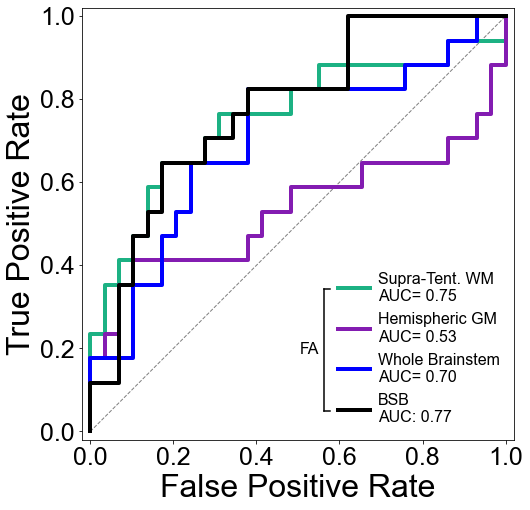

In [49]:
#### plot everything together!

fig = plt.figure(figsize=(10, 10))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg, tpr_tractseg, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm, tpr_cwm, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem, tpr_brainstem, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem))


# Plot BSB ROC curve
plt.plot(fpr, tpr, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)


bracket_x = 0.56 
bracket_top = 0.35
bracket_bottom = 0.067 


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.055, (bracket_top + bracket_bottom) / 2, 'FA', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/TBI_ROC_FA.png', dpi=300)
plt.show()


<ipython-input-50-2e7913dabe2c>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


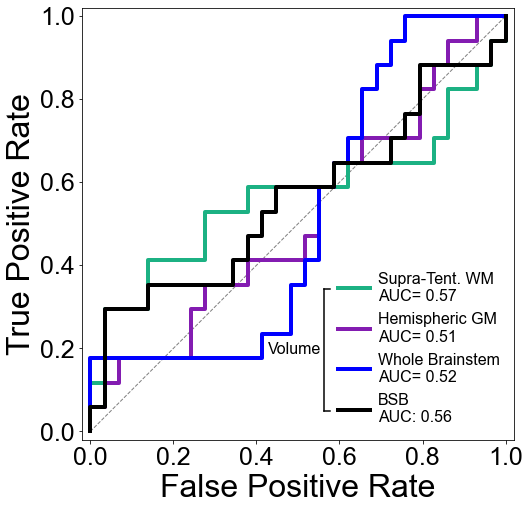

In [50]:
#### plot everything together!

fig = plt.figure(figsize=(10, 10))

plot_area = [0.2, 0.2, 0.6, 0.6] 
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_volume, tpr_tractseg_volume, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_volume))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_volume, tpr_cwm_volume, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_volume))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_volume, tpr_brainstem_volume, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_volume))


# Plot BSB ROC curve
plt.plot(fpr_volume, tpr_volume, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_volume))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)


bracket_x = 0.56  
bracket_top = 0.35 
bracket_bottom = 0.067 


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.13, (bracket_top + bracket_bottom) / 2, 'Volume', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/TBI_ROC_Volume.png', dpi=300)
plt.show()


In [51]:

p_delong_tractseg_bsb = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_tractseg))[0,0]
print("Tractseg-BSB p value: ", (10 ** p_delong_tractseg_bsb))


p_delong_bsb_bs = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_brainstem))[0,0]
print("Brainstem -BSB p value: ", (10 ** p_delong_bsb_bs))

p_delong_bsb_cwm = delong_roc_test(np.array(all_y_test), np.array(all_y_scores),np.array(all_y_scores_cwm))[0,0]
print("CWM-BSB p value: ", (10 ** p_delong_bsb_cwm))

aucs are:  [0.77484787 0.75456389]
Tractseg-BSB p value:  0.8484111331426822
aucs are:  [0.77484787 0.70385396]
Brainstem -BSB p value:  0.4745720141274386
aucs are:  [0.77484787 0.53346856]
CWM-BSB p value:  0.03533432939315701
